### Analyze the experiment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# Load dat
df = pd.read_csv("data/fin_dataset_treat_control.csv")
# Last 30 day downloads from pre-treat and downloads from 6/14
df_pre = pd.read_csv("data/bq_50kpypi_packages_30days_20230603-222533-1685831182985.csv")
#df_614 = pd.read_csv("data/bq_50kpypi_packages_30days_20230614-023307-1686710038094.csv")
df_720 = pd.read_csv("data/bq_50kpypi_packages_60days_20230720-094132-1689846147063.csv")

In [3]:
df['treatment'].value_counts()

treatment
0    19142
1     4823
Name: count, dtype: int64

In [4]:
print(df.shape)
print(df_720.shape)

(23965, 3)
(2629067, 4)


In [5]:
print(df['file_project'].nunique())
print(df_720['file_project'].nunique())

23965
23963


In [6]:
df_720['bot_or_not'] = df_720['installer_name'].replace({'pip': 'human', 
                                                 'Browser': 'bot', 
                                                 'bandersnatch': 'bot',
                                                 'setuptools': 'human',
                                                 'Nexus': 'human',
                                                 'requests': 'bot',
                                                 'devpi': 'bot',
                                                 'pdm': 'human',
                                                 'Homebrew': 'human',
                                                 'Artifactory': 'human',
                                                 'OS': 'human',
                                                 'Bazel': 'human',
                                                 'pex': 'human',
                                                 'conda': 'human',
                                                 'chaquopy': 'human',
                                                })
df_720.drop(['installer_name'], axis = 1)
df_720['bot_or_not'] = df_720['bot_or_not'].fillna('bot')
sdf_720 = df_720[df_720['bot_or_not'] == 'human']

In [7]:
gdf_720 = sdf_720.groupby(['file_project', 'timestamp_date'])['downloads'].sum().reset_index()

In [8]:
gdf_720.shape

(671449, 3)

In [9]:
# may need to have data for each of the 30 days. it doesn't seem we have
# it for all the packages
# Generate the date range with a 30-day window
#date_range = pd.date_range(end=df['timestamp_date'].max(), periods=30, freq='D')

# Create a new dataframe with the date range
#date_df = pd.DataFrame({'timestamp_date': date_range})
#merged_df = date_df.merge(df, on='timestamp_date', how='left').fillna(0)

In [10]:
# Convert 'timestamp_date' to datetime type
gdf_720['timestamp_date'] = pd.to_datetime(gdf_720['timestamp_date'])

# Sort the dataframe by 'file_project' and 'timestamp_date'
gdf_720.sort_values(by=['file_project', 'timestamp_date'], inplace=True)

gdf_720['cumulative_downloads'] = gdf_720.groupby('file_project')['downloads'].cumsum()

In [11]:
fin_df = df[['file_project', 'treatment']].merge(gdf_720, how = "left", on = "file_project")

In [12]:
fin_df.shape

(671498, 5)

In [13]:
fin_df.head()

,file_project,treatment,timestamp_date,downloads,cumulative_downloads
0,0-orchestrator,0,2023-05-21,1.0,1.0
1,0-orchestrator,0,2023-05-22,1.0,2.0
2,0-orchestrator,0,2023-05-23,4.0,6.0
3,0-orchestrator,0,2023-05-24,4.0,10.0
4,0-orchestrator,0,2023-05-25,7.0,17.0


In [14]:
# Convert the 'timestamp_date' column to datetime
#fin_df['timestamp_date'] = pd.to_datetime(fin_df['timestamp_date'])

# Calculate the daily means/medians by treatment group
daily_means = fin_df.groupby(['timestamp_date', 'treatment'])['cumulative_downloads'].mean().reset_index()
daily_medians = fin_df.groupby(['timestamp_date', 'treatment'])['cumulative_downloads'].median().reset_index()

In [15]:
daily_means[daily_means['treatment'] == 0].round()

,timestamp_date,treatment,cumulative_downloads
0,2023-05-21,0,3110.0
2,2023-05-22,0,8244.0
4,2023-05-23,0,15643.0
6,2023-05-24,0,20776.0
8,2023-05-25,0,25265.0
...,...,...,...
112,2023-07-16,0,363214.0
114,2023-07-17,0,309844.0
116,2023-07-18,0,316626.0
118,2023-07-19,0,326644.0


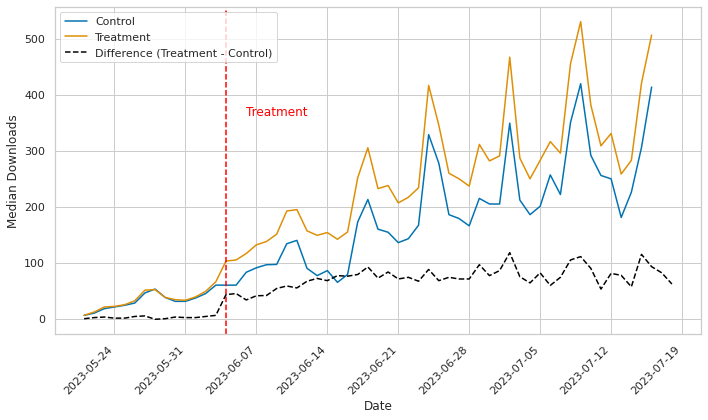

In [30]:
plt.figure(figsize=(10, 6))

for treatment, data in daily_medians[~daily_medians['timestamp_date'].\
                                     isin(['2023-07-22', '2023-07-21', 
                                           '2023-07-20', '2023-07-19',
                                           '2023-07-18', '2023-07-17'])].groupby('treatment'):
    label_text = 'Treatment' if treatment == 1 else 'Control'
    plt.plot(data['timestamp_date'], data['cumulative_downloads'], label=label_text)

# Calculate the difference between the two treatment groups
treatment_0_data = daily_medians[(daily_medians['treatment'] == 0) & ~daily_medians['timestamp_date'].isin(['2023-07-22', '2023-07-21', '2023-07-20', '2023-07-19'])]
treatment_1_data = daily_medians[(daily_medians['treatment'] == 1) & ~daily_medians['timestamp_date'].isin(['2023-07-22', '2023-07-21', '2023-07-20', '2023-07-19'])]
difference = treatment_1_data['cumulative_downloads'].values - treatment_0_data['cumulative_downloads'].values

# Treatment
plt.axvline(x=pd.to_datetime('2023-06-04'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-06-12'), plt.ylim()[1]-200, 'Treatment', color='red', va='bottom', ha='right')

# Plot the difference
plt.plot(treatment_0_data['timestamp_date'], difference, label='Difference (Treatment - Control)', color='black', linestyle='--')

#sns.set(style='whitegrid', palette='colorblind')

plt.xlabel('Date')
plt.ylabel('Median Downloads')
#plt.title('Daily Medians by Treatment Group')
plt.legend(loc='upper left')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

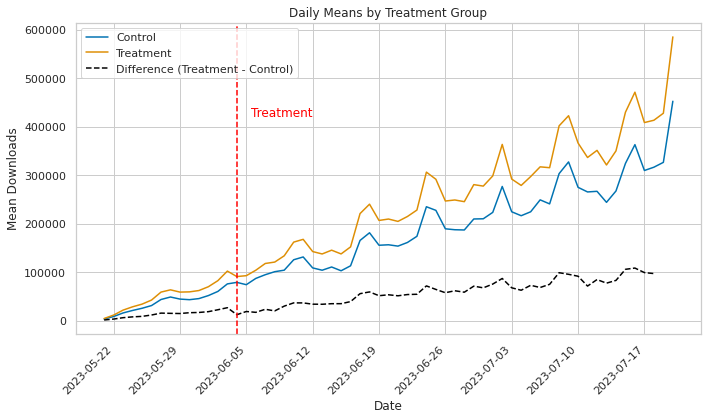

In [31]:
plt.figure(figsize=(10, 6))

# Taking out last week as generally it seems the data are adjusted for up to a week ...
for treatment, data in daily_means[~daily_means['timestamp_date'].\
                                   isin(['2023-07-22', '2023-07-21', 
                                         '2023-07-20', '2023-07-19'
                                         '2023-07-18', '2023-07-17'])].groupby('treatment'):
    label_text = 'Treatment' if treatment == 1 else 'Control'
    plt.plot(data['timestamp_date'], data['cumulative_downloads'], label=label_text)

# Calculate the difference between the two treatment groups
treatment_0_data = daily_means[(daily_means['treatment'] == 0) & ~daily_means['timestamp_date'].isin(['2023-07-22', '2023-07-21', '2023-07-20', '2023-07-19'])]
treatment_1_data = daily_means[(daily_means['treatment'] == 1) & ~daily_means['timestamp_date'].isin(['2023-07-22', '2023-07-21', '2023-07-20', '2023-07-19'])]
difference = treatment_1_data['cumulative_downloads'].values - treatment_0_data['cumulative_downloads'].values

# Plot the difference
plt.plot(treatment_0_data['timestamp_date'], difference, label='Difference (Treatment - Control)', color='black', linestyle='--')

# Treatment
plt.axvline(x=pd.to_datetime('2023-06-04'), color='red', linestyle='--')
plt.text(pd.to_datetime('2023-06-12'), plt.ylim()[1]-200000, 'Treatment', color='red', va='bottom', ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Mean Downloads')
plt.title('Daily Means by Treatment Group')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()